In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip


This library **below** can be used for spell checking:-

It is based **Symmetric Delete Spelling Correction** During offline training, pre-calculation is needed to execute to build a corpus. Generating word with edit distance (delete operation only) and connecting them with the original item. In order word, it use extra storage and memory resource to saving online prediction time. The new generated word will be used for searching and returning the original word if matched. During online prediction, input word go through same calculation and then searching it from pre-calculated result.
To read more [here](https://towardsdatascience.com/essential-text-correction-process-for-nlp-tasks-f731a025fcc3)

In [2]:
#!pip install -U symspellpy
# https://pypi.org/project/symspellpy/

In [3]:
#misc
import gc
import time
import warnings


#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

In [4]:
#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip


Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         


In [6]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')
test_labels=pd.read_csv('test_labels.csv')

In [7]:
train[100:110]# something from middle

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
100,003f698d06c9b180,"However, the Moonlite edit noted by golden dap...",0,0,0,0,0,0
101,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0,0,0,0
102,0040017ef6277334,i can't believe no one has already put up this...,0,0,0,0,0,0
103,004176f28a17bf45,"""\n\nWell, after I asked you to provide the di...",0,0,0,0,0,0
104,0044cf18cc2655b3,What page shoudld there be for important chara...,0,0,0,0,0,0
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
106,00480b6e1f19601b,I tend to think that when the list is longer t...,0,0,0,0,0,0
107,0048de0c9422f64f,"""\n\n What's up with this? \n""""If you are a re...",0,0,0,0,0,0
108,0048e4ed8a0af433,I'm not vandalizing \n\nI'm just having fun m...,0,0,0,0,0,0
109,004a23742282fee4,Welcome to Wikipedia ! [bla] Discover Ekopedia...,0,0,0,0,0,0


In [8]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


No Null Values

CLASS IMBALANCE CHECK

In [9]:
x=train.iloc[:,2:].sum()
x#COLUMN wise sum

fig = px.bar( x=x.index, y=x.values,
             height=400)
fig.show()


In [10]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [11]:
train #how data looks now

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,True
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,True
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,True
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,True


In [12]:
#helper function will use later
# toxic_df=train.loc[(train['toxic']==1)&(train['severe_toxic']==0)&(train['obscene']==0)&
#                   (train['threat']==0)&(train['insult']==0)&(train['identity_hate']==0)]
# toxic_df

CHECK MULTI-TAGING

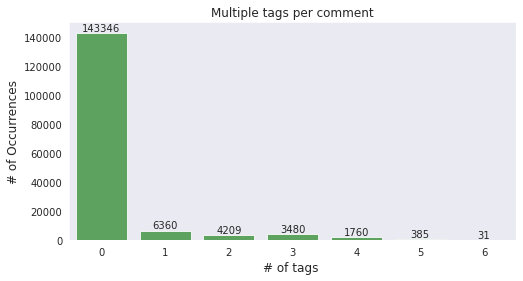

In [13]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

credits for above graph=https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

### A look at toxic data

In [14]:
print(train[train.severe_toxic==1].iloc[3,1]) # printing column 1(actual comment) of 3rd severe toxic comment
print('#########################')
print(train[train.identity_hate==1].iloc[4,1])

Hi 

Im a fucking bitch.

50.180.208.181
#########################
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


* our data contains:-
        1. IP address
        2. Random characters
        3. usernames(FDGH123)
They can cause huge overfitting so we will do some **DATA CLEANING**

## FEATURES we will choose

DIRECT FEATURES
        1. Unigrams
        1. BIGRAMS
        2. TRIGRAMS
  
Choose one comment

Other Approaches

        *.Length of the comment - my initial assumption is that angry people write short messages
        * Number of capitals - observation was many toxic comments being ALL CAPS
        * Proportion of capitals - see previous
        * Number of exclamation marks - i observed several toxic comments with multiple exclamation marks
        * Number of question marks - assumption that angry people might not use question marks
        * Number of punctuation symbols - assumption that angry people might not use punctuation
        * Number of symbols - assumtion that words like fck or $# or sh*t mean more symbols in foul language (Thx for tip!)
        * Number of words - angry people might write short messages?
        * Number of unique words - observation that angry comments are sometimes repeated many times
        * Proportion of unique words - see previous
        * Number of (happy) smilies - Angry people wouldn't use happy smilies, right?

Split the comment into all possible n-grams where n ranges from 1 to len(tweet) ( OUR N=4)

Calculate n-gram-level features (for each n-gram)
    1. n-gram lengths
    2. n-gram lengths divided by comment length (proportion)

Calculate non-n-gram-level features (for each n-gram)
    1. comment length minus n-gram lengths
    2. (comment length minus n-gram lengths) divided by comment length (proportion)



In [15]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,True
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,True
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,True
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,True


### SOME data cleaning

In [16]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
# Applying the cleaning function to both test and training datasets
train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanationwhy the edits made under my usernam...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,morei cant make any real suggestions on improv...,0,0,0,0,0,0,True
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when your vi...,0,0,0,0,0,0,True
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0,True
159568,ffee36eab5c267c9,spitzer umm theres no actual article for prost...,0,0,0,0,0,0,True
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0,True


In [17]:
test['comment_text'] = test['comment_text'].apply(lambda x: clean_text(x))

## Emoji checking

In [18]:
import emoji
def find_emoji(text):
    emo_text=emoji.demojize(text)
    line=re.findall(r'\:(.*?)\:',emo_text)
    return line


for i in range(1000):# we run this operation for first 10 comments and see if any emoji's
    line=find_emoji(train['comment_text'][i])
    if len(line)==0:
        continue
    else:
        print(line)
        print(i)


['left-right_arrow', 'spade_suit', 'club_suit', 'heart_suit', 'diamond_suit']
126
['trade_mark']
137
['telephone']
143
['heart_suit', 'heart_suit', 'heart_suit', 'heart_suit']
189
['spade_suit', 'heart_suit', 'diamond_suit', 'club_suit']
407
['Statue_of_Liberty']
425
['telephone']
599
['diamond_suit']
664
['heart_suit', 'heart_suit', 'heart_suit', 'heart_suit', 'heart_suit', 'heart_suit', 'heart_suit', 'heart_suit', 'heart_suit']
728
['spade_suit', 'club_suit', 'heart_suit', 'diamond_suit', 'trade_mark', 'copyright', 'registered']
764
['heart_suit']
972


### So we have lot of Emoji's and instead of removing them we can use them for our help

In [19]:
def use_emoji(text):
    text=emoji.demojize(str(text))
    text=re.sub(':','',text)
    text=re.sub(r'\:(.*?)\:','',text)
    return text

train['comment_text']=train['comment_text'].apply(lambda x: use_emoji(x))

In [20]:
test['comment_text']=test['comment_text'].apply(lambda x: use_emoji(x))

##### Example comment

In [21]:
train['comment_text'][126]

'ahh hello witzeman   symbols   ¡ ¿ † ‡ left-right_arrow ↑ ↓ • ¶    ½ ⅓ ⅔ ¼ ¾ ⅛ ⅜ ⅝ ⅞ ∞   ‘ “ ’ ” «»   ¤ ₳ ฿ ₵ ¢ ₡ ₢  ₫ ₯ € ₠ ₣ ƒ ₴ ₭ ₤ ℳ ₥ ₦ № ₧ ₰ £ ៛ ₨ ₪ ৳ ₮ ₩ ¥   spade_suit club_suit heart_suit diamond_suit   m² m³ characters á á ć ć é é í í ĺ ĺ ń ń ó ó ŕ ŕ ś ś ú ú ý ý ź ź   à à è è ì ì ò ò ù ù   â â ĉ ĉ ê ê ĝ ĝ ĥ ĥ î î ĵ ĵ ô ô ŝ ŝ û û ŵ ŵ ŷ ŷ   ä ä ë ë ï ï ö ö ü ü ÿ ÿ   ß   ã ã ẽ ẽ ĩ ĩ ñ ñ õ õ ũ ũ ỹ ỹ   ç ç ģ ģ ķ ķ ļ ļ ņ ņ ŗ ŗ ş ş ţ ţ   đ đ   ů ů   ǎ ǎ č č ď ď ě ě ǐ ǐ ľ ľ ň ň ǒ ǒ ř ř š š ť ť ǔ ǔ ž ž   ā ā ē ē ī ī ō ō ū ū ȳ ȳ ǣ ǣ   ǖ ǘ ǚ ǜ ă ă ĕ ĕ ğ ğ ĭ ĭ ŏ ŏ ŭ ŭ   ċ ċ ė ė ġ ġ i̇ ı ż ż   ą ą ę ę į į ǫ ǫ ų ų   ḍ ḍ ḥ ḥ ḷ ḷ ḹ ḹ ṃ ṃ ṇ ṇ ṛ ṛ ṝ ṝ ṣ ṣ ṭ ṭ   ł ł   ő ő ű ű   ŀ ŀ   ħ ħ   ð ð þ þ   œ œ   æ æ ø ø å å   ə ə    greek ά ά έ έ ή ή ί ί ό ό ύ ύ ώ ώ   α α β β γ γ δ δ   ε ε ζ ζ η η θ θ   ι ι κ κ λ λ μ μ   ν ν ξ ξ ο ο π π   ρ ρ σ σ ς τ τ υ υ   φ φ χ χ ψ ψ ω ω    cyrillic а а б б в в г г   ґ ґ ѓ ѓ д д ђ ђ   е е ё ё є є ж ж   з з ѕ ѕ и и і і   ї ї й й ј ј к к   ќ ќ л л љ љ м м   н н њ њ 

### Removing accents(German and French example) and weird spaces from text

In [22]:
#https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii=re.sub(' +', ' ',(only_ascii.decode('utf-8')))
    return only_ascii
train['comment_text']=train['comment_text'].apply(lambda x: remove_accents(x))

In [23]:
test['comment_text']=test['comment_text'].apply(lambda x: remove_accents(x))

In [24]:
train['comment_text'][126]

'ahh hello witzeman symbols left-right_arrow 12 13 23 14 34 18 38 58 78 M No Rs spade_suit club_suit heart_suit diamond_suit m2 m3 characters a a c c e e i i l l n n o o r r s s u u y y z z a a e e i i o o u u a a c c e e g g h h i i j j o o s s u u w w y y a a e e i i o o u u y y a a e e i i n n o o u u y y c c g g k k l l n n r r s s t t u u a a c c d d e e i i l l n n o o r r s s t t u u z z a a e e i i o o u u y y u u u u a a e e g g i i o o u u c c e e g g i z z a a e e i i o o u u d d h h l l l l m m n n r r r r s s t t o o u u l l a a greek cyrillic ipa t d h w j n l my famous article witze happiness wikipedia the witzeman is a great honour that has been passed down through the generations of many families regardless of race age character or knowledge the outside world knows little about these elusive characters and the honour of the witzeman for those who have ever been a witzeman it has been said to have been a great honour although the qualities needed for the job have never 

### Remove single characters like (b,c,d ...z) not **a** because it can act as <font color='red'>article</font>

In [25]:
def singles(text):
    ws=str(text)
    w=' '.join( [w for w in ws.split() if (len(w)>1) and w not in ['b','c','d','e','f','g'
                                                                  ,'h','i','j','k','l','m',
                                                                  'n','o','p','q','r','s','t'
                                                                  ,'u','v','w','x','y','z']] )
    return w
train['comment_text']=train['comment_text'].apply(lambda x: singles(x))

In [26]:
test['comment_text']=test['comment_text'].apply(lambda x: singles(x))

In [27]:
train['comment_text'][126] # this was the dirtiest comment i could found :)

'ahh hello witzeman symbols left-right_arrow 12 13 23 14 34 18 38 58 78 No Rs spade_suit club_suit heart_suit diamond_suit m2 m3 characters greek cyrillic ipa my famous article witze happiness wikipedia the witzeman is great honour that has been passed down through the generations of many families regardless of race age character or knowledge the outside world knows little about these elusive characters and the honour of the witzeman for those who have ever been witzeman it has been said to have been great honour although the qualities needed for the job have never been disclosed person may not now they were witzeman for many years until they are called by former witzemans via dreams associates of the witzeman are known to be certain babe cool or the much lesser known witzewomanthe present witzeman is an boy namely benjamin woods who is said to have become witzeman after he felt this awesome radiance in his topright bumcheek he has not told great number of people his testimony but has 

### Removing repetitive characters

In [28]:
def rep(text):
    grp = text.group(0)
    if len(grp) > 1:
        return grp[0:1] # can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert
sentence="heyyy this is loong textttt sooon"
unique_char(rep,sentence)

'hey this is long text son'

In [29]:
train['comment_text']=train['comment_text'].apply(lambda x:unique_char(rep,x))


In [30]:
test['comment_text']=test['comment_text'].apply(lambda x:unique_char(rep,x))


### After removing repetitive characters

In [31]:
train['comment_text'][126]

'ah helo witzeman symbols left-right_arow 12 13 23 14 34 18 38 58 78 No Rs spade_suit club_suit heart_suit diamond_suit m2 m3 characters grek cyrilic ipa my famous article witze hapines wikipedia the witzeman is great honour that has ben pased down through the generations of many families regardles of race age character or knowledge the outside world knows litle about these elusive characters and the honour of the witzeman for those who have ever ben witzeman it has ben said to have ben great honour although the qualities neded for the job have never ben disclosed person may not now they were witzeman for many years until they are caled by former witzemans via dreams asociates of the witzeman are known to be certain babe col or the much leser known witzewomanthe present witzeman is an boy namely benjamin wods who is said to have become witzeman after he felt this awesome radiance in his topright bumchek he has not told great number of people his testimony but has promised to do so in y

## we have done all possible data preprocessing yes we could have removed numbers but some numers make sense:

    1. Humans has 10 fingers.so here we cant remove numer it  will sense-less
    2. We could have removed phone numbers but in all countries Phone number is not of 10 digits so couldn't find any specific patterns

### There may be chances  that word that appears in Training does not appear in Test set hence 
### we had to do next step

In [32]:
g=pd.concat([train, test]) # all text
g.shape

(312735, 9)

In [33]:
### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 1k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)

#change back to min=10 to get better results

#https://stackoverflow.com/questions/46118910/scikit-learn-vectorizer-max-features
tfv = TfidfVectorizer(min_df=10,max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,token_pattern=r'\w{1,}',
            stop_words = 'english')
tfv.fit(g['comment_text'])
features = np.array(tfv.get_feature_names())

diffrence bw fit(),transform() and fit_transform()
present [here](https://stackoverflow.com/questions/23838056/what-is-the-difference-between-transform-and-fit-transform-in-sklearn)

In [34]:
train_word_features = tfv.transform(train['comment_text'])
test_word_features = tfv.transform(test['comment_text'])

## Bigrams

In [35]:
word_vectorizer2 = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(2, 2),
    max_features=10000)
word_vectorizer2.fit(g['comment_text'])
train_word_features2 = word_vectorizer2.transform(train['comment_text'])
test_word_features2 = word_vectorizer2.transform(test['comment_text'])

In [36]:
train_word_features2.shape

(159571, 10000)

In [37]:
from scipy.sparse import hstack
train_features = hstack([train_word_features, train_word_features2])
test_features = hstack([test_word_features, test_word_features2])


## Trigrams

In [38]:
word_vectorizer3 = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(3, 3),
    max_features=10000)
word_vectorizer3.fit(g['comment_text'])
train_word_features3 = word_vectorizer3.transform(train['comment_text'])
test_word_features3 = word_vectorizer3.transform(test['comment_text'])

In [39]:
final_train_features=hstack([train_features,train_word_features3])
final_test_features=hstack([test_features,test_word_features3])

In [40]:
print(final_train_features.shape,final_test_features.shape)

(159571, 30000) (153164, 30000)


In [41]:
scores = []
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, final_train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(final_train_features, train_target)
    submission[class_name] = classifier.predict_proba(final_test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

submission.to_csv('submission.csv', index=False)

CV score for class toxic is 0.9531541236472144
CV score for class severe_toxic is 0.9820805277516139
CV score for class obscene is 0.9722230971812641
CV score for class threat is 0.9804126762788602
CV score for class insult is 0.9648776361020683
CV score for class identity_hate is 0.9650059524138189
Total CV score is 0.9696256688958066


In [42]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.738836,0.032702,0.543343,0.004869,0.429569,0.032936
1,0000247867823ef7,0.044729,0.006908,0.026805,0.002861,0.028279,0.007840
2,00013b17ad220c46,0.029722,0.005328,0.017382,0.002402,0.018340,0.006209
3,00017563c3f7919a,0.020947,0.005001,0.013861,0.002375,0.014391,0.005036
4,00017695ad8997eb,0.097476,0.005989,0.036694,0.002797,0.035771,0.007373
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.062290,0.006363,0.026053,0.002719,0.029166,0.007445
153160,fffd7a9a6eb32c16,0.099514,0.007700,0.044812,0.003347,0.045038,0.009787
153161,fffda9e8d6fafa9e,0.034456,0.005586,0.021196,0.002559,0.021695,0.006384
153162,fffe8f1340a79fc2,0.057794,0.006345,0.028823,0.002822,0.028862,0.010938


### Below cells are Not for this kernel

In [43]:
import pickle
filename = 'finalized_model.pkl'
with open(filename, 'wb') as file:  
    pickle.dump(classifier, file)

In [44]:
with open(filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)


In [45]:
# Dump the file
pickle.dump(tfv, open("unigran.pkl", "wb"))
pickle.dump(word_vectorizer2,open('bigram.pkl','wb'))
pickle.dump(word_vectorizer3,open('trigram.pkl','wb'))

In [46]:
from scipy.sparse import hstack
def prediction_fun(text):
    f1=tfv.transform(text)
    f2=word_vectorizer2.transform(text)
    semi=hstack([f1,f2])
    f3=word_vectorizer3.transform(text)
    final=hstack([semi,f3])
    temporary=pd.DataFrame(columns=['id'])
    temporary=temporary.append({"id":1},ignore_index=True)

    submission12 = pd.DataFrame.from_dict({'id': temporary['id']})
    for class_name in class_names:
        print(class_name)
        print(classifier.predict_proba(final)[:, 1])
        submission12[class_name] = classifier.predict_proba(final)[:, 1]
    return submission12


In [47]:
text="""sources zawe ashton on lapland"""
temp=pd.DataFrame(columns=['text'])
temp=temp.append({'text':text},ignore_index=True)
prediction_fun([temp['text'][0]])
# temp['text'][0]

toxic
[0.00620903]
severe_toxic
[0.00620903]
obscene
[0.00620903]
threat
[0.00620903]
insult
[0.00620903]
identity_hate
[0.00620903]


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0.006209,0.006209,0.006209,0.006209,0.006209,0.006209


In [48]:
# col_name_1=[]
# for i in range(1,501):
#     col_name_1.append('uni_f_'+str(i))
# unigram_features=pd.DataFrame(columns=col_name_1)

In [49]:
# train_vector=train_vector.toarray()

In [50]:
# comment_length=train['comment_text'].apply(lambda x :len(x))#feature will use soon

In [51]:
# _1gram_feature=features

In [52]:
# _1gram=[]
# for j in range(len(c)):
#     ls=[]
#     for i in features:
#         if i in  train['comment_text'][j]:
#             ls.append(len(i))
#     _1gram.append(sum(ls))

In [53]:
# _1gram_len_norm=[round((i-min(_1gram))/(max(_1gram)-min(_1gram)),3) for i in _1gram ]# normalizing values of 1 gram lengths

In [54]:
# _1gram_len_norm=np.asarray(_1gram_len_norm)

In [55]:
# _1gram_len_norm=_1gram_len_norm.reshape(10000,1)

In [56]:
# train_vector=np.append(train_vector,_1gram_len_norm,axis=1)